In [1]:
%load_ext autotime

time: 625 µs (started: 2021-12-31 19:20:41 +01:00)


In [2]:
import logging
import time
from contextlib import contextmanager
import os
from multiprocessing import Process
import psutil

import numpy as np
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string
import warnings
warnings.simplefilter(action='ignore', category=Warning)

/Users/soso/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


time: 6.47 s (started: 2021-12-31 19:20:41 +01:00)


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

time: 3.93 s (started: 2021-12-31 19:20:48 +01:00)


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'vs'])

time: 1.21 s (started: 2021-12-31 19:20:52 +01:00)


# 1 - Import Data

In [5]:
y = pd.read_csv('/Users/soso/Desktop/IML_P5/y_export_v2.csv', dtype=str) 
X = pd.read_csv('/Users/soso/Desktop/IML_P5/X_export_v2.csv', dtype=str) 

X = X.head(10000)
X

,Sentence
0,question intends technology agnostic kind web ...
1,python metaclasses use metaclasses python
2,logging lognet easy put class called log log f...
3,make facebook rss application autoupdates prov...
4,good regular expression validate text string m...
...,...
9995,one responses question asked yesterday suggest...
9996,building enterprise application net sql server...
9997,created vsto c supposed hook outlook newmailex...
9998,looking ideas elements user interface device m...


time: 1.77 s (started: 2021-12-31 19:20:53 +01:00)


# 2 - Cleaning

In [6]:
# Convert to list
data = X.Sentence.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['question intends technology agnostic kind web framework prefer pure mvc '
 'event driven component oriented make point technology agnosticism name mvc '
 'vs component web frameworks diverse technologies languages struts vs java '
 'server faces tapestry new asp net mvc vs classic asp net cake php vs prado '
 'mvc event driven component oriented web frameworks']
time: 1.62 s (started: 2021-12-31 19:20:55 +01:00)


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['question', 'intends', 'technology', 'agnostic', 'kind', 'web', 'framework', 'prefer', 'pure', 'mvc', 'event', 'driven', 'component', 'oriented', 'make', 'point', 'technology', 'agnosticism', 'name', 'mvc', 'vs', 'component', 'web', 'frameworks', 'diverse', 'technologies', 'languages', 'struts', 'vs', 'java', 'server', 'faces', 'tapestry', 'new', 'asp', 'net', 'mvc', 'vs', 'classic', 'asp', 'net', 'cake', 'php', 'vs', 'prado', 'mvc', 'event', 'driven', 'component', 'oriented', 'web', 'frameworks']]
time: 6.52 s (started: 2021-12-31 19:20:56 +01:00)


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['question', 'intends', 'technology', 'agnostic', 'kind', 'web', 'framework', 'prefer', 'pure', 'mvc', 'event', 'driven', 'component', 'oriented', 'make', 'point', 'technology', 'agnosticism', 'name', 'mvc', 'vs', 'component', 'web', 'frameworks', 'diverse', 'technologies', 'languages', 'struts', 'vs', 'java', 'server', 'faces', 'tapestry', 'new', 'asp_net_mvc', 'vs', 'classic_asp', 'net', 'cake', 'php', 'vs', 'prado', 'mvc', 'event', 'driven', 'component', 'oriented', 'web', 'frameworks']
time: 37.2 s (started: 2021-12-31 19:21:03 +01:00)


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

time: 3.32 ms (started: 2021-12-31 19:21:40 +01:00)


In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['question', 'intend', 'technology', 'agnostic', 'kind', 'web', 'framework', 'prefer', 'pure', 'mvc', 'event', 'drive', 'orient', 'make', 'point', 'technology', 'agnosticism', 'name', 'framework', 'diverse', 'technology', 'language', 'strut', 'face', 'new', 'net', 'event', 'drive', 'orient', 'web', 'framework']]
time: 2min 14s (started: 2021-12-31 19:21:40 +01:00)


# 3 - Prepare

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 2)]]
time: 2.53 s (started: 2021-12-31 19:23:55 +01:00)


# 4 - Non-SuperVisée

In [12]:
nmf = GensimNmf(
    corpus=corpus,
    num_topics=5,
    id2word=id2word,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

time: 10.1 s (started: 2021-12-31 19:23:58 +01:00)


In [13]:
nmf.show_topics()

[(0,
  '0.028*"code" + 0.014*"function" + 0.013*"string" + 0.013*"would" + 0.010*"want" + 0.008*"work" + 0.007*"project" + 0.007*"example" + 0.007*"get" + 0.007*"make"'),
 (1,
  '0.105*"file" + 0.010*"user" + 0.009*"use" + 0.009*"open" + 0.008*"server" + 0.008*"error" + 0.007*"directory" + 0.007*"want" + 0.007*"run" + 0.007*"change"'),
 (2,
  '0.042*"class" + 0.029*"public" + 0.021*"return" + 0.019*"system" + 0.017*"error" + 0.014*"private" + 0.014*"new" + 0.013*"int" + 0.012*"value" + 0.011*"string"'),
 (3,
  '0.033*"object" + 0.032*"table" + 0.014*"datum" + 0.013*"d" + 0.013*"name" + 0.012*"database" + 0.012*"user" + 0.010*"value" + 0.010*"use" + 0.010*"column"'),
 (4,
  '0.030*"use" + 0.017*"application" + 0.011*"web" + 0.011*"server" + 0.011*"work" + 0.010*"way" + 0.010*"would" + 0.008*"window" + 0.008*"run" + 0.007*"build"')]

time: 182 ms (started: 2021-12-31 19:24:08 +01:00)


# 5 - Scoring

In [14]:
cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=id2word,
        coherence='c_v'
    )
cm.get_coherence()

0.42378876538650206

time: 12.2 s (started: 2021-12-31 19:24:08 +01:00)


In [ ]:
coherence_values = []




for i in range(2,20,1):
    nmf = GensimNmf(
        corpus=corpus,
        num_topics=i,
        id2word=id2word,
        chunksize=1000,
        passes=5,
        eval_every=10,
        minimum_probability=0,
        random_state=0,
        kappa=1,
    )
    
    cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=id2word,
            coherence='c_v'
        )
    sc_coh = cm.get_coherence()
    coherence_values.append([i, sc_coh])
    print('nb topic: ', i , 'coherence_values :' , sc_coh)



nb topic:  2 coherence_values : 0.3898543276383245
nb topic:  3 coherence_values : 0.4142821340203298


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/soso/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/soso/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/__init__.py", line 5, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, summarization, utils  # noqa:F401
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/parsing/__init__.py", line 4, in <module>
    from .preprocessing import (remove_stopwords, strip_punctuation, strip_punctuation2,  # noqa:F401
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/parsing/preprocessing.py", line 42, in <module>
    from gensim import utils
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/ge

Traceback (most recent call last):
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nk/77tzydc5271b4jt6909jb9m80000gn/T/ipykernel_5227/1447875184.py", line 25, in <module>
    sc_coh = cm.get_coherence()
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/models/coherencemodel.py", line 609, in get_coherence
    confirmed_measures = self.get_coherence_per_topic()
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/models/coherencemodel.py", line 569, in get_coherence_per_topic
    self.estimate_probabilities(segmented_topics)
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/models/coherencemodel.py", line 541, in estimate_probabilities
    self._accumulator = self.measure.prob(**kwargs)
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/topic_coherence/probability_estimat

2021-12-31 19:25:02,772 : ERROR : Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nk/77tzydc5271b4jt6909jb9m80000gn/T/ipykernel_5227/1447875184.py", line 25, in <module>
    sc_coh = cm.get_coherence()
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/models/coherencemodel.py", line 609, in get_coherence
    confirmed_measures = self.get_coherence_per_topic()
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/models/coherencemodel.py", line 569, in get_coherence_per_topic
    self.estimate_probabilities(segmented_topics)
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/models/coherencemodel.py", line 541, in estimate_probabilities
    self._accumulator = self.measure.prob(**kwargs)
  File "/Users/soso/opt/anaconda3/lib/python3.8/site-packages/gensim/topic_coherence/probability_estimat

In [24]:
data =[[2 , 0.3898543276383245],
[3 , 0.44519887031885624],
[4 , 0.42385926690509124],
[5 , 0.42378876538650206],
[6 , 0.4476689521785137],
[7 , 0.44204125648982523],
[8 , 0.44753046805684943],
[9 , 0.43470293169319213],
[10,  0.4144717495297610],
[11,  0.4318431219708264],
[12,  0.4456987105970827],
[13,  0.4237495596567114],
[14,  0.4155854954080072],
[15,  0.4430434570962982],
[16,  0.4229805071764896],
[17,  0.4420075004198107],
[18,  0.4220200164348506],
[19,  0.429249256537426]]


df = pd.DataFrame(data)
df = df.rename(columns={0: "Nb Topics", 1: "Coherance_Score"})
df

,Nb Topics,Coherance_Score
0,2,0.389854
1,3,0.445199
2,4,0.423859
3,5,0.423789
4,6,0.447669
5,7,0.442041
6,8,0.447530
7,9,0.434703
8,10,0.414472
9,11,0.431843


time: 24.5 ms (started: 2021-12-31 19:25:15 +01:00)


# 6 - Visualisation

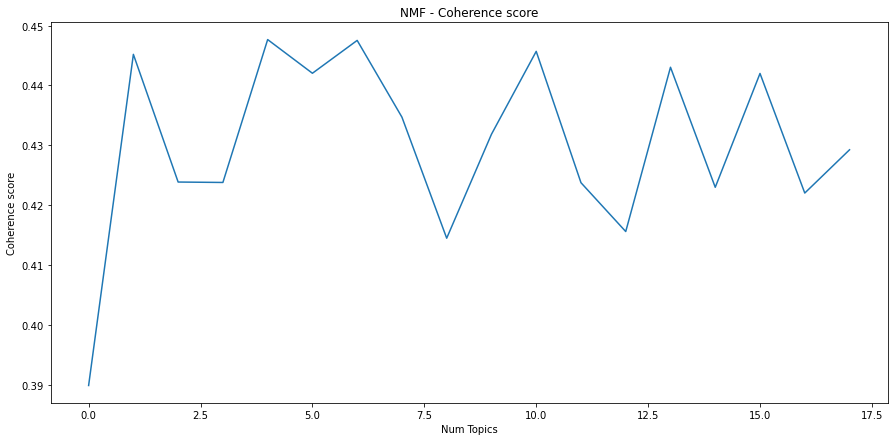

time: 447 ms (started: 2021-12-31 19:25:15 +01:00)


In [25]:
plt.figure(figsize=(15,7))
plt.plot(df.Coherance_Score)
plt.ylabel('Coherence score')
plt.xlabel('Num Topics')
plt.title('NMF - Coherence score')
plt.show()

## 6.1 - Best Model

In [31]:
# Best 6 topics



nmf = GensimNmf(
    corpus=corpus,
    num_topics=6,
    id2word=id2word,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

time: 11.2 s (started: 2021-12-31 19:27:47 +01:00)


# 7 - Result

In [36]:
a = nmf.show_topics()
b = pd.DataFrame(a)
c = b[1].str.split('"', expand=True)
for i in range (0,21,2):
    c.pop(i)
k=1
for i in range (1,21,2):
    new_col = "Word_" + str(k)
    c = c.rename(columns={i: new_col})
    k +=1
Topics = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6']
 
# Using 'Address' as the column name
# and equating it to the list
c['Topics'] = Topics
c = c.set_index('Topics')
c

,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
Topics,,,,,,,,,,
Topic_1,class,object,public,return,method,code,private,function,string,call
Topic_2,use,run,work,code,server,test,try,project,application,get
Topic_3,user,would,way,want,good,page,control,application,need,list
Topic_4,table,database,row,d,column,datum,record,select,query,value
Topic_5,file,project,use,open,want,directory,way,read,line,include
Topic_6,name,value,false,type,error,system,web,property,new,right


time: 191 ms (started: 2021-12-31 19:29:58 +01:00)


# Semi-SuperVisé

In [93]:
XY = pd.read_csv('/Users/soso/Desktop/IML_P5/export_clean_df.csv', dtype=str) 
XY

,Txt_Clean,Tags_Clean
0,python metaclasses use,python oop metaclass class datamodel
1,good regular expression validate text string m...,c regex
2,two unsorted lists need produce another list s...,algorithm sort lisp list
3,tools like selenium good testing user interact...,test browser user interface
4,like know easier way insert record already exi...,c linq sql
...,...,...
38897,company perl application server ip new rule im...,mysql perl mariadb dbi
38898,typescript compiler compile optional chaining ...,typescript language design
38899,using mockk spy kotlin java class field anonym...,kotlin mockk
38900,hoping try cro library raku https services doc...,raku cro


time: 258 ms (started: 2021-12-31 20:03:20 +01:00)


In [94]:
y = pd.DataFrame(XY.Tags_Clean)
X = pd.DataFrame(XY.Txt_Clean)

time: 5.94 ms (started: 2021-12-31 20:03:20 +01:00)


In [95]:
x_feat = 3439
vetorizar = TfidfVectorizer(max_features=x_feat) 
X = pd.DataFrame(vetorizar.fit_transform(X.Txt_Clean).toarray())
print(X.shape)

(38902, 3439)
time: 3.44 s (started: 2021-12-31 20:03:20 +01:00)


In [96]:
from sklearn.feature_extraction.text import CountVectorizer
y_feat = 100
vectorizer = CountVectorizer(max_features=y_feat)
y = pd.DataFrame(vectorizer.fit_transform(y.Tags_Clean).toarray(), columns=vectorizer.get_feature_names())
print(y.shape)

(38902, 100)
time: 368 ms (started: 2021-12-31 20:03:24 +01:00)


In [97]:
from sklearn.decomposition import NMF
model = NMF(n_components=6, random_state=5)
# Fit the model to TF-IDF
model.fit(X)
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

time: 1min 14s (started: 2021-12-31 20:03:24 +01:00)


In [104]:
def avg_jacard(y_true,y_pred):
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)    
    return jacard.mean()*100

    
def print_score(y_pred, y_test):
    print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
    print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
    print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(metrics.hamming_loss(y_pred, y_test)*100))
    print("---")

time: 2.03 ms (started: 2021-12-31 20:06:21 +01:00)


In [99]:
nmf_features_df = pd.DataFrame(nmf_features)

print(y.shape)
print(nmf_features_df.shape)

X_train =  nmf_features_df.iloc[0:10000]
X_test =  nmf_features_df.iloc[10000:20000]
y_train = y.iloc[0:10000]
y_test = y.iloc[10000:20000]


print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

(38902, 100)
(38902, 6)
X_train : (10000, 6)
X_test : (10000, 6)
y_train : (10000, 100)
y_test : (10000, 100)
time: 217 ms (started: 2021-12-31 20:04:39 +01:00)


In [110]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from datetime import datetime

model_1 = SGDClassifier(alpha=1e-05, loss='log')
model_2 = LogisticRegression(max_iter=10000)
model_3 = ExtraTreesClassifier()
model_4 = RandomForestClassifier(n_estimators=50, random_state=0)
model_5 = LGBMClassifier() 
model_6 = LinearSVC(class_weight='balanced', max_iter=10000)


print(str(model_1),'  ', datetime.now().strftime("%H:%M:%S"))
clf_1 = OneVsRestClassifier(model_1)
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_test)
print_score(y_pred,y_test)

print(str(model_2),'  ', datetime.now().strftime("%H:%M:%S"))
clf_2 = OneVsRestClassifier(model_2)
clf_2.fit(X_train, y_train)
y_pred = clf_2.predict(X_test)
print_score(y_pred,y_test)

print(str(model_3),'  ', datetime.now().strftime("%H:%M:%S"))
clf_3 = OneVsRestClassifier(model_3)
clf_3.fit(X_train, y_train)
y_pred = clf_3.predict(X_test)
print_score(y_pred,y_test)

print(str(model_4),'  ', datetime.now().strftime("%H:%M:%S"))
clf_4 = OneVsRestClassifier(model_4)
clf_4.fit(X_train, y_train)
y_pred = clf_4.predict(X_test)
print_score(y_pred,y_test)

print(str(model_5),'  ', datetime.now().strftime("%H:%M:%S"))
clf_5 = OneVsRestClassifier(model_5)
clf_5.fit(X_train, y_train)
y_pred = clf_5.predict(X_test)
print_score(y_pred,y_test)

print(str(model_6),'  ', datetime.now().strftime("%H:%M:%S"))
clf_6 = OneVsRestClassifier(model_6)
clf_6.fit(X_train, y_train)
y_pred = clf_6.predict(X_test)
print_score(y_pred,y_test)



SGDClassifier(alpha=1e-05, loss='log')    21:25:01
Accuracy : 0.1782
Macro f1 score : 0.018446761552542677
Micro f1 score : 0.10070516929891019
Jacard score: 4.330432172869142
Hamming loss: 1.5431
---
LogisticRegression(max_iter=10000)    21:25:04
Accuracy : 0.17
Macro f1 score : 0.0009236389075473511
Micro f1 score : 0.008730901153726224
Jacard score: 0.3001284830964425
Hamming loss: 1.5895
---
ExtraTreesClassifier()    21:25:08
Accuracy : 0.1791
Macro f1 score : 0.036502280868447035
Micro f1 score : 0.18087557603686638
Jacard score: 8.632444855517276
Hamming loss: 1.5642
---
RandomForestClassifier(n_estimators=50, random_state=0)    21:27:08
Accuracy : 0.1871
Macro f1 score : 0.03672386551699692
Micro f1 score : 0.19100646940290594
Jacard score: 9.107819905213297
Hamming loss: 1.5256
---
LGBMClassifier()    21:29:11
Accuracy : 0.1791
Macro f1 score : 0.045543711583540494
Micro f1 score : 0.197050869942344
Jacard score: 9.246400343402131
Hamming loss: 1.5737
---
LinearSVC(class_weight

In [114]:
def _my_score_(idx):
    row_pred_1 = pd.DataFrame(y_pred_df.iloc[idx])
    row_pred_1 = row_pred_1.sort_values(by=[idx], ascending=False)
    row_pred_2 = row_pred_1.head(3)
    row_pred_2 = row_pred_2.reset_index()
    row_pred_2.pop(idx)
    row_pred_2 = row_pred_2.rename(columns={'level_0': "Find_tag"})
    row_pred_val = row_pred_2.Find_tag.values
    row_pred_val = row_pred_val.tolist()
    len_pred_val = len(row_pred_val)
    # ---
    y_test_1 = pd.DataFrame(y_test).reset_index()
    y_test_1.pop('index')
    row_test_1 = pd.DataFrame(y_test_1.iloc[idx])
    row_test_1 = row_test_1[row_test_1[idx] > 0]
    row_test_1 = row_test_1.reset_index()
    row_test_1.pop(idx)
    row_test_1 = row_test_1.rename(columns={'index': "Real_tag"})
    row_real_val = row_test_1.Real_tag.values
    row_real_val = row_real_val.tolist()
    len_real_val = len(row_real_val)
    #----
    compare = set(row_pred_val) & set(row_real_val)
    len_compare_ok  = len(compare)
    #----
    row.append([len_pred_val,len_real_val,len_compare_ok])

time: 1.87 ms (started: 2021-12-31 21:41:31 +01:00)


In [115]:
_len_ = y_test.shape[0]


lst_mod = [clf_1, clf_2,clf_3,clf_4,clf_5]
for xXx in lst_mod:
    print(xXx)
    y_proba_df = xXx.predict_proba(X_test)
    y_pred_df = pd.DataFrame(y_proba_df, columns=[y.columns])
    row = []
    for i in range(_len_):
        _my_score_(i)
    eval_df = pd.DataFrame(row, columns=['Pred','Real','Match'])
    eval_df['Eval'] = eval_df['Match'] / eval_df['Real']
    _eval_val = eval_df.Eval.mean(axis = 0)

    print('My Score : ' , _eval_val)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log'))
My Score :  0.3045212857487012
OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))
My Score :  0.29142231934932483
OneVsRestClassifier(estimator=ExtraTreesClassifier())
My Score :  0.2990849881267847
OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                     random_state=0))
My Score :  0.310030141904991
OneVsRestClassifier(estimator=LGBMClassifier())
My Score :  0.323574927441466
time: 12min 43s (started: 2021-12-31 21:41:33 +01:00)


In [ ]:
data = [
["SGDClassifier - Semi - NMF", 0.30, 0.17,0.01,0.10,4,1.54, 1],
["LogisticRegression - Semi - NMF",0.29,  0.17,0.00,0.00,0.30,1.58, 1],
["ExtraTreesClassifier - Semi - NMF", 0.29, 0.17,0.03, 0.18,8,1.56, 1],
["RandomForestClassifier - Semi - NMF", 0.31, 0.18,0.03, 0.19,9,1.52, 1],
["LGBMClassifier - Semi - NMF",0.32, 0.17,0.04,0.19,9,1.57, 1]]